# SuperNet на MNIST

Проводится эксперимент по обучению суперсети определённой архитектуры на датасете MNIST. На каждой итерации с помощью заданного типа сэмплирования выбирается подсеть в пространстве поиска, обучение которой и происходит. Рассматривается два типа сэмплирования: равномерное сэмплирование и сэмплирование на основе стохастического бандитского алгоритма Epsilon-Greedy. Также проводится независимое обучение подсетей. Оценка качества подсетей на тестовом датасете показывает, что имеет место высокая корреляция целевой метрики для подсетей, обученных в рамках суперсети и независимо. Это позволяет определять лучшие архитектуры при использовании меньшего количества ресурсов. Приводятся проблемы данного подхода и способы их решения.

## Подготовка

### Загрузка набора данных

In [1]:
from torchvision.datasets import MNIST

In [2]:
DATASET_PATH = './data'

MNIST(DATASET_PATH, train=True, download=True)
MNIST(DATASET_PATH, train=False, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 102732936.60it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 60176698.37it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26572907.18it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8686971.62it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

### Установка пакета для эксперимента

In [3]:
!pip install "git+https://github.com/basic-go-ahead/supernet-mnist.git"

  Cloning https://github.com/basic-go-ahead/supernet-mnist.git to /tmp/pip-req-build-ib9uxuz2
  Running command git clone --filter=blob:none --quiet https://github.com/basic-go-ahead/supernet-mnist.git /tmp/pip-req-build-ib9uxuz2
  Resolved https://github.com/basic-go-ahead/supernet-mnist.git to commit cce34c0b28c1135107005cb5643d69c0aeddf3a1
  Preparing metadata (setup.py) ... done
  Created wheel for src: filename=src-1.0-py3-none-any.whl size=10819 sha256=5157cfce32149d2ce08211cd64f7ac3692309ca497699dd351a34129ead8d56a
  Stored in directory: /tmp/pip-ephem-wheel-cache-og7_6saq/wheels/c8/17/c5/8a6b7b72bfd4087c821615e6cc0aba3617578896a013c87761
Successfully built src


In [4]:
from src.models import admissible_architectures
from src.utils import logged_metrics
from src.utils.visualization import display_accuracy_dynamics

## Гипотезы

### Гипотеза №1

---

Поскольку все присутствуюшие в NAS-блоках подблоки разделяются между подсетями, то интуитивно первые из них могут служить хорошо предобученными для последующих подблоков, что может способствовать увеличению целевой метрики. То есть чем больше подблоков в NAS-блоке, тем лучше.

---

### Гипотеза №2

---

Поскольку `stride > 1` обычно применяется для повышения вычислительной производительности и способствует определённой потери информации, то чем больше подблоков в NAS-блоке, следующим за общим блоком (фиолетового цвета) с `stride = 2`, тем больше возможностей для восстановления важных признаков, утерянных из-за `stride`, что должно приводить к большей точности. То есть количество подблоков во втором NAS-блоке может быть ключевым фактором увеличения целевой метрики в пространстве поиска.

---

### Гипотеза №3

---

Количество подблоков в первом NAS-блоке также должно увеличивать целевую метрику, поскольку большее (но всё же ограниченное) число параметров позволяет выделить лучшие признаки перед фиолетовым блоком.

---

## I. Обучение SuperNet с помощью равномерного сэмплирования 

### Обучение SuperNet

In [5]:
!train_model --dataset-path {DATASET_PATH} \
    --epochs 3 \
    --model-path 'supernet-u.pt' \
    --sampler 'uniform' \
    --sampler-history-path 'uniform-sampling'

Training SuperNet with uniform sampler...
Epoch 03: mean_train_loss = 0.27063: 100%|█| 1875/1875 [00:16<00:00, 115.42it/s]


Здесь и далее тип архитектуры подсети задаётся парой, компоненты которой определяют
количество подблоков первого и второго NAS-блока соответственно.

Рассмотрим динамику точности подсетей при обучении суперсети.

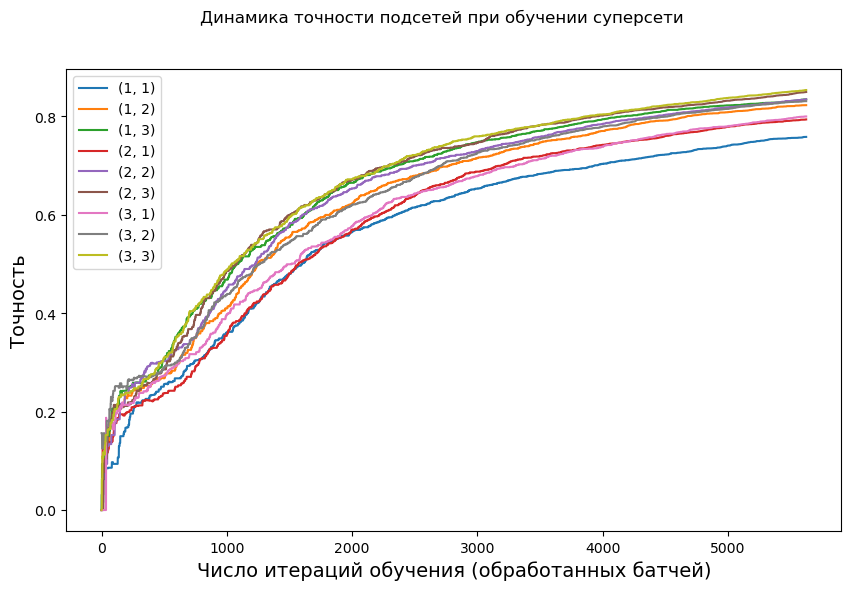

In [6]:
display_accuracy_dynamics("uniform-sampling")

Динамика точности при обучении подсетей, обученных в рамках суперсети, в целом согласуется с предложенными гипотезами:

- (в пользу второй гипотезы) подсети образуют три группы по значениям метрики:
    - в группе лидеров подсети, имеющие три подблока во втором NAS-блоке (архитектура (1, 3) практически не отличается от (3, 2) и (2, 2), поэтому выбираем её как представителя);
    - вторая группа содержит подсети, у которых два блока во втором NAS-блоке;
    - нацонец, третья группа подсетей с худшими показателями имеет один подблок во втором NAS-блоке;
- (в пользу третьей гипотезы) в целом в каждой группе сети с большим числом подблоков в первом NAS-блоке превалируют над своими согруппниками.

### Оценка качества подсетей

In [7]:
!eval_model --dataset-path {DATASET_PATH} --model-path 'supernet-u.pt'

Evaluating Arch(1, 1)...
Top-1 Acc = 0.84859: 100%|█████████████████| 1875/1875 [00:10<00:00, 187.26it/s]
Evaluating Arch(1, 2)...
Top-1 Acc = 0.93859: 100%|█████████████████| 1875/1875 [00:09<00:00, 198.32it/s]
Evaluating Arch(1, 3)...
Top-1 Acc = 0.95005: 100%|█████████████████| 1875/1875 [00:08<00:00, 212.32it/s]
Evaluating Arch(2, 1)...
Top-1 Acc = 0.93490: 100%|█████████████████| 1875/1875 [00:08<00:00, 217.18it/s]
Evaluating Arch(2, 2)...
Top-1 Acc = 0.96205: 100%|█████████████████| 1875/1875 [00:09<00:00, 195.51it/s]
Evaluating Arch(2, 3)...
Top-1 Acc = 0.96786: 100%|█████████████████| 1875/1875 [00:09<00:00, 199.37it/s]
Evaluating Arch(3, 1)...
Top-1 Acc = 0.94818: 100%|█████████████████| 1875/1875 [00:08<00:00, 209.66it/s]
Evaluating Arch(3, 2)...
Top-1 Acc = 0.96887: 100%|█████████████████| 1875/1875 [00:09<00:00, 206.05it/s]
Evaluating Arch(3, 3)...
Top-1 Acc = 0.97156: 100%|█████████████████| 1875/1875 [00:09<00:00, 191.61it/s]


Результаты оценки подсетей, обученных в рамка суперсети, на тестовом датасете играют немного против второй гипотезы, поскольку архитектура (2, 2) показала результат, превосходящий результат архитектуры (1, 3).

Окончательный вывод можно будет сделать при независимом обучении подсетей.

Третья гипотеза пока полностью подтверждается: при фиксированном размере второго NAS-блока и росте размера первого NAS-блока увеличивается точность.

### Независимое обучение подсетей

In [8]:
for arch in admissible_architectures:
    !train_model --dataset-path {DATASET_PATH} \
        --epochs 3 \
        --model-path subnet{arch[0]}{arch[1]}.pt \
        --architecture {arch[0]} {arch[1]}

Training Arch(1, 1)...
Epoch 03: mean_train_loss = 0.28554: 100%|█| 1875/1875 [00:13<00:00, 142.39it/s]
Training Arch(1, 2)...
Epoch 03: mean_train_loss = 0.12597: 100%|█| 1875/1875 [00:15<00:00, 124.45it/s]
Training Arch(1, 3)...
Epoch 03: mean_train_loss = 0.07442: 100%|█| 1875/1875 [00:16<00:00, 116.83it/s]
Training Arch(2, 1)...
Epoch 03: mean_train_loss = 0.19719: 100%|█| 1875/1875 [00:14<00:00, 125.79it/s]
Training Arch(2, 2)...
Epoch 03: mean_train_loss = 0.09714: 100%|█| 1875/1875 [00:16<00:00, 112.95it/s]
Training Arch(2, 3)...
Epoch 03: mean_train_loss = 0.06271: 100%|█| 1875/1875 [00:16<00:00, 112.13it/s]
Training Arch(3, 1)...
Epoch 03: mean_train_loss = 0.14954: 100%|█| 1875/1875 [00:15<00:00, 120.92it/s]
Training Arch(3, 2)...
Epoch 03: mean_train_loss = 0.08269: 100%|█| 1875/1875 [00:15<00:00, 120.49it/s]
Training Arch(3, 3)...
Epoch 03: mean_train_loss = 0.05413: 100%|█| 1875/1875 [00:16<00:00, 112.69it/s]


In [9]:
for arch in admissible_architectures:
    !eval_model --dataset-path {DATASET_PATH} --model-path subnet{arch[0]}{arch[1]}.pt

Evaluating Arch(1, 1)...
Top-1 Acc = 0.95023: 100%|█████████████████| 1875/1875 [00:10<00:00, 182.97it/s]
Evaluating Arch(1, 2)...
Top-1 Acc = 0.97727: 100%|█████████████████| 1875/1875 [00:09<00:00, 188.78it/s]
Evaluating Arch(1, 3)...
Top-1 Acc = 0.98934: 100%|█████████████████| 1875/1875 [00:10<00:00, 174.94it/s]
Evaluating Arch(2, 1)...
Top-1 Acc = 0.96219: 100%|█████████████████| 1875/1875 [00:10<00:00, 184.16it/s]
Evaluating Arch(2, 2)...
Top-1 Acc = 0.98352: 100%|█████████████████| 1875/1875 [00:10<00:00, 170.85it/s]
Evaluating Arch(2, 3)...
Top-1 Acc = 0.98953: 100%|█████████████████| 1875/1875 [00:10<00:00, 178.02it/s]
Evaluating Arch(3, 1)...
Top-1 Acc = 0.96731: 100%|█████████████████| 1875/1875 [00:11<00:00, 165.03it/s]
Evaluating Arch(3, 2)...
Top-1 Acc = 0.98345: 100%|█████████████████| 1875/1875 [00:11<00:00, 165.29it/s]
Evaluating Arch(3, 3)...
Top-1 Acc = 0.99003: 100%|█████████████████| 1875/1875 [00:11<00:00, 158.65it/s]


Приведём таблицу с оценкой подсетей, обученных в рамках суперсети и независимо.

In [10]:
df = logged_metrics("eval.log")
df

,Подсеть,Top-1 Acc на SuperNet,Top-1 Acc независимо
0,"(1, 1)",0.850450,0.950550
1,"(1, 2)",0.939433,0.977400
2,"(1, 3)",0.950950,0.989417
3,"(2, 1)",0.935633,0.962617
4,"(2, 2)",0.962383,0.983733
5,"(2, 3)",0.968250,0.989617
6,"(3, 1)",0.948717,0.967717
7,"(3, 2)",0.969100,0.983567
8,"(3, 3)",0.971783,0.990117


А также посчитаем корреляцию между значениями метрик.

In [11]:
df[["Top-1 Acc на SuperNet", "Top-1 Acc независимо"]].corr()

,Top-1 Acc на SuperNet,Top-1 Acc независимо
Top-1 Acc на SuperNet,1.000000,0.856576
Top-1 Acc независимо,0.856576,1.000000


### Выводы по эксперименту

- Наблюдается очень высокая корреляция между значениями метрик при обучении в рамках суперсети и независимо. Таким образом, использование суперсети эффективно с точки зрения использования ресурсов для определения лучшей архитектуры: потребовалось меньше времени для обучения суперсети, чем всех подсетей независимо.

- Вторая и третья гипотеза полностью подтверждены, причём количество подблоков во втором NAS-блоке является ключевым фактором роста целевой метрики.

### Потенциальные проблемы

1. Оценка подсетей, обученных в рамках суперсети, показала, что можно сделать ложный вывод о превосходстве одной архитектуры над другой, как это показал пример с архитектурами (1, 3) и (2, 2). Это может быть проблемой при выборе компромиссной архитектуры, когда требуется определить архитектуру приемлемого качества с меньшим или одинаковым количеством весов.

2. Равномерное сэмплирование не учитывает точность подсети при обучении, что может просто приводить к трате ресурсов на обучение заведомо плохих подсетей, что особенно критично, когда пространство поиска огромно.

### Подходы к решению проблем

Вторую проблему можно решать с помощью сужения пространства поиска при наборе статистики о подсетях в рамках обучения суперсети. Это может быть что-то вроде pruning, как для древесных алгоритмов.

Также можно уделять меньшее количество ресурсов на обучение подсетей, которые при наборе статистики показывают себя недостаточно хорошо. Это можно сделать с помощью сэмплирования на основе алгоритмов, учитывающих историю точности подсетей, например, стохастических бандитов или алгоритмов предсказания с помощью экспертов.

Первая проблема подталкивает к идее определения лидера среди подсетей и предоставления ему больших ресурсов при обучении суперсети.

Всё это делается в следующем разделе, где суперсеть обучается при алгоритме сэмплирования Epsilon-Greedy.

Ещё про решение первой проблемы: конкурирующие подсети можно попробовать выделить из суперсети и дообучить несколько эпох, чтобы определить лучшую. Пока этот эксперимент не проводится в тетрадке.

## II. Обучение SuperNet с помощью Epsilon-Greedy сэмплирования

### Гипотеза №4

---

Лучшую архитектуру подсети можно попробовать выявить за меньшее количество эпох с помощью сэмплирования на основе алгоритма Epsilon-Greedy:
- для набора статистики в рамках первых `n` (100) раундом используется равномерное сэмплирование;
- в дальнейшем с вероятностью `ε` (0.2) используется равномерное сэмплирование, а в противном случае выбирается подсеть-лидер по целевой метрике.

---

Хотя Epsilon-Greedy концентрируется на лидере подсетей по Top-1 Acc, он также даёт возможность другим подсетям вырваться вперёд, что важно, поскольку все подсети разделяют часть весов друг с другом.

In [12]:
!train_model --dataset-path {DATASET_PATH} \
    --epochs 1 \
    --model-path 'supernet-eg.pt' \
    --sampler 'epsilon-greedy' \
    --sampler-history-path 'epsilon-greedy-sampling'

Training SuperNet with epsilon-greedy sampler...
Epoch 01: mean_train_loss = 0.93576: 100%|██| 1875/1875 [00:21<00:00, 87.03it/s]


В процессе обучения суперсети Epsilon-Greedy уверенно выбирает лидера, а также другие подсети, у которых во втором NAS-блоке три подблока. Кроме того, по динамике точности видно, что сети хорошо кластеризуются (в отличие от ситуации равномерного сэмплирования), как по количеству блоков в первом, так и втором NAS-блоке.

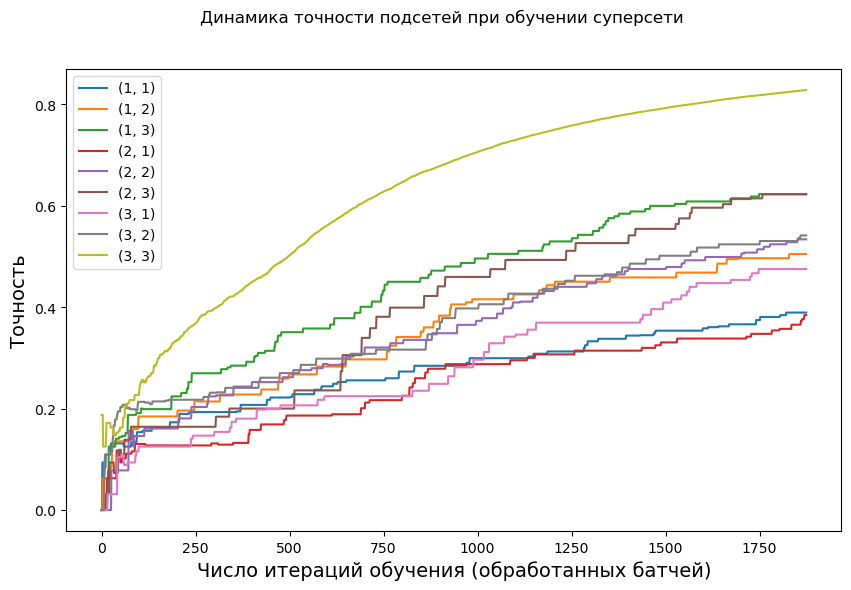

In [13]:
display_accuracy_dynamics("epsilon-greedy-sampling")

In [14]:
!eval_model --dataset-path {DATASET_PATH} --model-path 'supernet-eg.pt'

Evaluating Arch(1, 1)...
Top-1 Acc = 0.43194: 100%|█████████████████| 1875/1875 [00:10<00:00, 178.43it/s]
Evaluating Arch(1, 2)...
Top-1 Acc = 0.65003: 100%|█████████████████| 1875/1875 [00:09<00:00, 191.26it/s]
Evaluating Arch(1, 3)...
Top-1 Acc = 0.76102: 100%|█████████████████| 1875/1875 [00:09<00:00, 198.89it/s]
Evaluating Arch(2, 1)...
Top-1 Acc = 0.61950: 100%|█████████████████| 1875/1875 [00:09<00:00, 201.15it/s]
Evaluating Arch(2, 2)...
Top-1 Acc = 0.74431: 100%|█████████████████| 1875/1875 [00:09<00:00, 190.15it/s]
Evaluating Arch(2, 3)...
Top-1 Acc = 0.82512: 100%|█████████████████| 1875/1875 [00:10<00:00, 180.92it/s]
Evaluating Arch(3, 1)...
Top-1 Acc = 0.73102: 100%|█████████████████| 1875/1875 [00:09<00:00, 193.60it/s]
Evaluating Arch(3, 2)...
Top-1 Acc = 0.88599: 100%|█████████████████| 1875/1875 [00:09<00:00, 193.57it/s]
Evaluating Arch(3, 3)...
Top-1 Acc = 0.96844: 100%|█████████████████| 1875/1875 [00:10<00:00, 178.30it/s]
